### **Title : Using Known Patient Health Statistics to Determine an Incoming Patient's Diagnosis of Heart Disease**

In [3]:
# loading necessary packages

library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(10)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.4     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ──────────────────────

### **Introduction**
Coronary Artery Disease(CAD) has been identified as the most common heart disease that often presents as chest pain due to significant narrowing of the major arteries around the heart. It has now become a wide spread epidemic on a global scale to the extent that it is now considered the foremost cause of premature mortality and loss of life. In low and middle income countries alone, CAD accounts for nearly 7 million deaths and 129 million DALYs annually(DALYs is a unit of measurement that determines how many years of healthy life was loss either by premature mortality or development of long term disability as a result of contracting CAD)(Ralapanawa & Sivakanesan, 2021). Even though the United States of America has always been considered to be a high income country, it also struggles with the prevention and treatment of CAD. Estimates inidcate that around 18.2 million American adults already have CAD (U.S. Department of Health and Human Services). Furthermore, the city of Cleveland, OH has officially been identified as the poorest city within the US, reported to have the highest unemployment and poverty rates. However, little study has been done to quantify the spread of CAD within such low income areas(Campbell, 2020). Taking this information into account, it is clear that it is important to study CAD among low income areas such as Cleveland to get a better picture of the health and well being of US citizens living in such areas. Since it is unrealistic to perform medical biopsies on every citizen to collect this data, we must use other methods such as statistics and modeling to predict if a person has or is at risk of CAD.

**Question: Can we use the demographic data and health metrics of patients with a known diagnosis to predict whether a future patient is at a risk of developing coronary artery disease**

We use the Cleveland heart disease data (Janosi et al., 1988), which is a comma separated value (csv) file. The dataset contains a collection of health metrics and demographics from various patients residing in Cleveland. It also contains the diagnosis of each patient, with values from 0 to 4 where 0 indicates absence of heart disease and values 1-4 indicate presence. We believe tthat it is reasonable to imply that heart disease here refers to the Coronary Artery Disease because of CAD is the most common form of heart disease in the USA and globally. More importantly, the researchers for this dataset classified patients whose major arteries have narrowed by more than 50% to be the ones who are positive for heart disease, where the narrowing of arteries are predominantly described as symptoms of CAD (Centers for Disease Control and Prevention, 2021). Hence, we will try to predict whether or not a patient has a risk of CAD.

In order to do so, we will use the K-Nearest Neighbors classification algorithm to determine the diagnosis for new unknown patients that have not been seen by the model.

**Hypothesis: We hypothesize that the age, cholestrol level, blood pressure, max heartrate and oldpeak will be able to correctly predict the diagnosis and that patients with a positive diagnosis risk will be in higher age groups and have overall higher blood pressure, cholestrol levels, max heartrates and oldpeak values.**

### **Loading the Data**

In [4]:
#loading the dataset with appropriate column names

cleveland_data<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")
colnames(cleveland_data)<-c("age","sex","chest_pain","rest_bps","cholestrol_level","high_fbs?",
                            "rest_electrographics","max_heartrate","exercise_induced_angina","oldpeak","slope",
                            "colored_major_vessels","thal","diagnosis")
cleveland_data


New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain,rest_bps,cholestrol_level,high_fbs?,rest_electrographics,max_heartrate,exercise_induced_angina,oldpeak,slope,colored_major_vessels,thal,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


**Table 1:** Initial heart disease dataset before cleaning and wrangling occurs. As the original datframe did not have column names, they have been provided to help provide better clarity for each potential predictor variable.

Included below is the data dictionary created for our specific dataframe using descriptions from the source (UCI Machine Learning Repository)

*age(numerical): age in years*

*sex: sex (1 = male; 0 = female)*

chest_pain: chest pain type<br>
1: typical angina<br>
2: atypical angina<br>
3: non-anginal pain<br>
4: asymptomatic

*rest_bps(numerical): resting blood pressure (in mm Hg on admission to the hospital)*

*cholestrol_level(numerical): serum cholestoral in mg/dl*

*high_fbs? (boolean): (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)*

*rest_electrographics: resting electrocardiographic results*<br>
0: normal<br>
1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)<br>
2: showing probable or definite left ventricular hypertrophy by Estes' criteria

*max_heartrate(numerical): maximum heart rate achieved by patient under strenuous exercise*

*exercise_induced_angina (boolean): exercise induced angina (1 = yes; 0 = no)*

*oldpeak: ST depression induced by exercise relative to rest (Extent of reduction of blood supply to the heart due to narrowing of coronary arteries during exercise)*<br>
Higher Oldpeak values indicate reduced blood supply and a higher chance of cardiovascular events 

*slope: the slope of the peak exercise ST segment*<br>
1: upsloping<br>
2: flat<br>
3: downsloping

*colored_major_vessels: number of major vessels (0-3) colored by flourosopy*

*thal: 3 = normal; 6 = fixed defect; 7 = reversable defect*

*diagnosis: diagnosis of heart disease (angiographic disease status)*<br>
0: Absent<br>
1,2,3,4: Present<br>
*patients with more than 50% narrowing in their major vessels were classified to have a heart disease(present)*

There are 5 numerical variables in the dataset (age, cholestrol level, resting blood pressure, max heartrate and oldpeak) that could have potentially acted as predictor variables for the classification algorithm model predicting diagnosis. In order to determine which variables to use for our predictors, we summarized and visualized the variables below to observe if the distribution of datapoints for presence or absence of heart disease is affected by the potential predictor variables.

### **Cleaning and Summarizing the Data**

We cleaned and wrangled the dataset by selecting only the numerical variables and mutating the predicted attribute diagnosis into a categorical variable with two human readable categories(absent and present). We also split the original dataset to training(75%) and testing(25%) sets using the `initial_split()` function. The training data will be used to design predictive model (classifier) in the following code.

In [5]:
#cleaning and wrangling the data into tidy format and splitting it into training and testing sets

set.seed(1000) #setting a seed to ensure reproducibility 

cleveland_clean<-cleveland_data|>
                select(age, rest_bps, max_heartrate, cholestrol_level, oldpeak, diagnosis)|>
                mutate(diagnosis=case_when(diagnosis==0~"Absent",diagnosis==1~"Present",
                                         diagnosis==2~"Present",diagnosis==3~"Present",diagnosis==4~"Present")) |>
                mutate(diagnosis = as_factor(diagnosis))

cleveland_split <- initial_split(cleveland_clean, prop = 0.75, strata = diagnosis)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)
cleveland_train
cleveland_test

age,rest_bps,max_heartrate,cholestrol_level,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37,130,187,250,3.5,Absent
56,120,178,236,0.8,Absent
57,140,148,192,0.4,Absent
⋮,⋮,⋮,⋮,⋮,⋮
57,140,123,241,0.2,Present
57,130,115,131,1.2,Present
57,130,174,236,0.0,Present


age,rest_bps,max_heartrate,cholestrol_level,oldpeak,diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,130,172,204,1.4,Absent
62,140,160,268,3.6,Present
57,120,163,354,0.6,Absent
⋮,⋮,⋮,⋮,⋮,⋮
58,125,144,220,0.4,Absent
45,110,132,264,1.2,Present
68,144,141,193,3.4,Present


**Tables 2 and 3:** Training and Testing Data

We then calculated the mean of each potential predictor for the two classes and the count of observations in each class using the `group_by()` and `summarize()` functions.

In [6]:
predictor_summary<- cleveland_train |>
                        group_by(diagnosis) |>
                        summarize(across(age:oldpeak, mean),count = n()) |>
                        rename("Mean Age" = age,
                                "Mean Rest_BPS"=rest_bps,
                               "Mean Maximum Heartrate" = max_heartrate,
                               "Mean Cholestrol Level"=cholestrol_level,
                               "Mean Oldpeak"=oldpeak,
                               "Diagnosis" = diagnosis,
                                "No of Patients"=count)

predictor_summary

Diagnosis,Mean Age,Mean Rest_BPS,Mean Maximum Heartrate,Mean Cholestrol Level,Mean Oldpeak,No of Patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Present,56.66346,134.4615,139.9904,248.1346,1.5134615,104
Absent,51.80328,128.4180,159.5328,244.8689,0.5663934,122


**Table 3:** Summary Statistics

In the summary table above, there are a fewer number of patients at risk than those who are not, but this number is relatively small and hence there was no need to upsample the data. Further, it can be seen from the mean values that oldpeak and maximum heart rate have very different mean values for the two classes and hence can be used as predictors. We have also visualized the variables below using graphs to better understand the spread of the variables and find other possible predictors.

### **Visualizing the Data**

We used the `ggplot()` and `geom_hist()` functions to create histograms to visualize the distributions of potential predictor variables according to the two classes. To divide each histogram into two rows for the Present and Absent classes, we used the `facet_grid()` function.

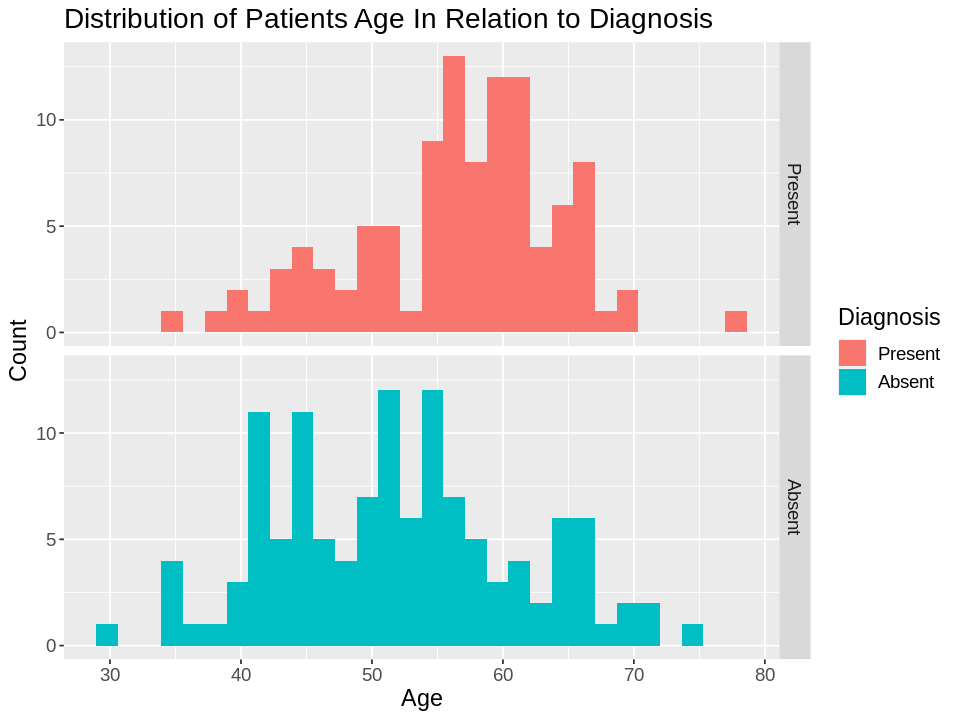

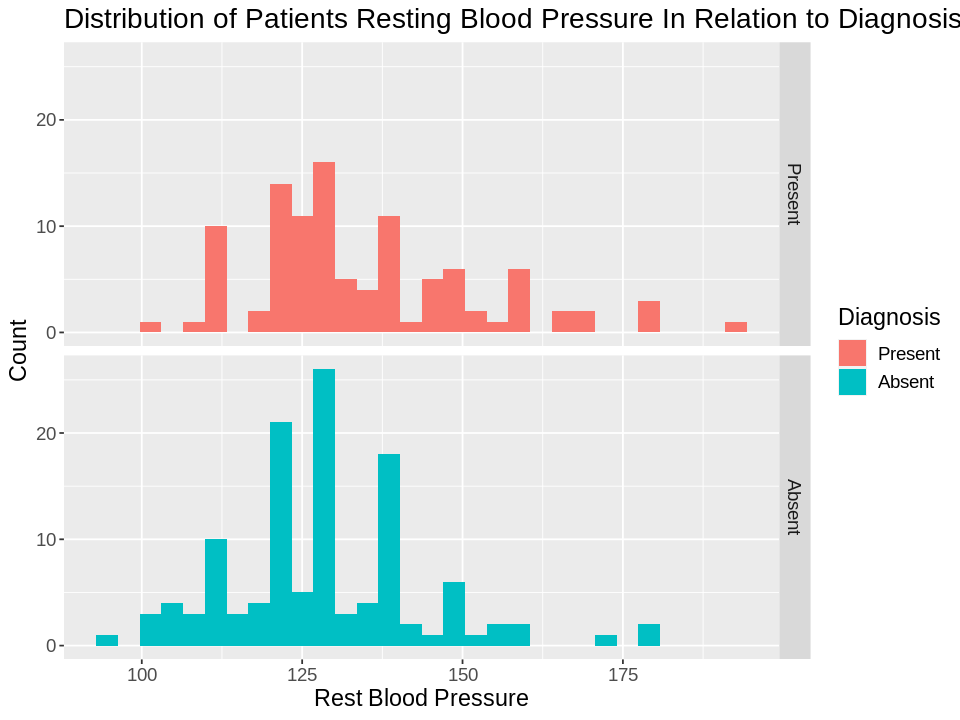

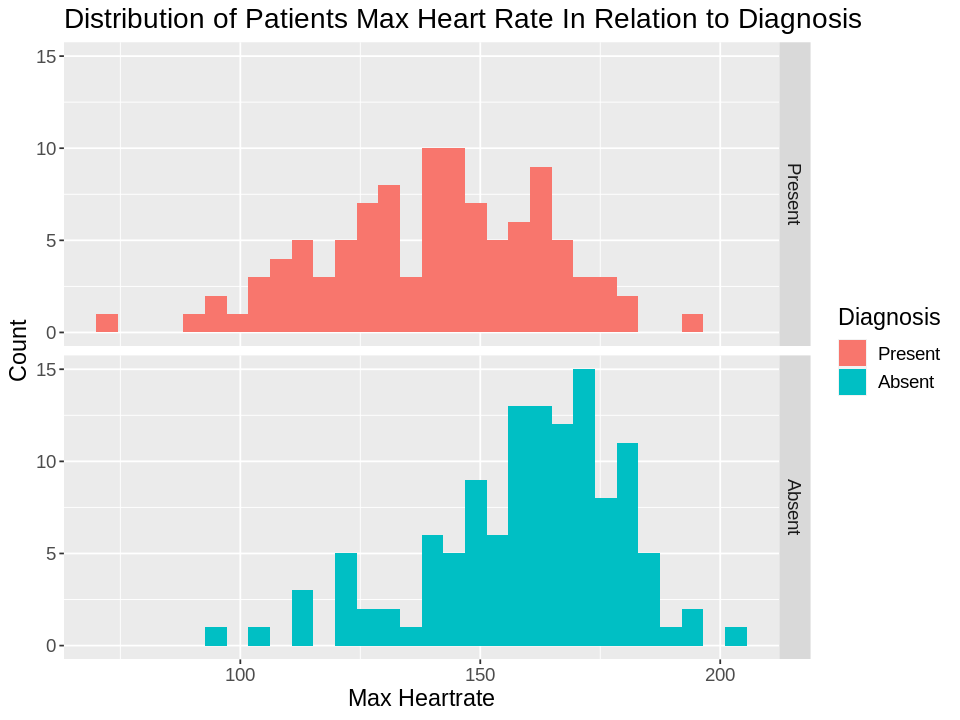

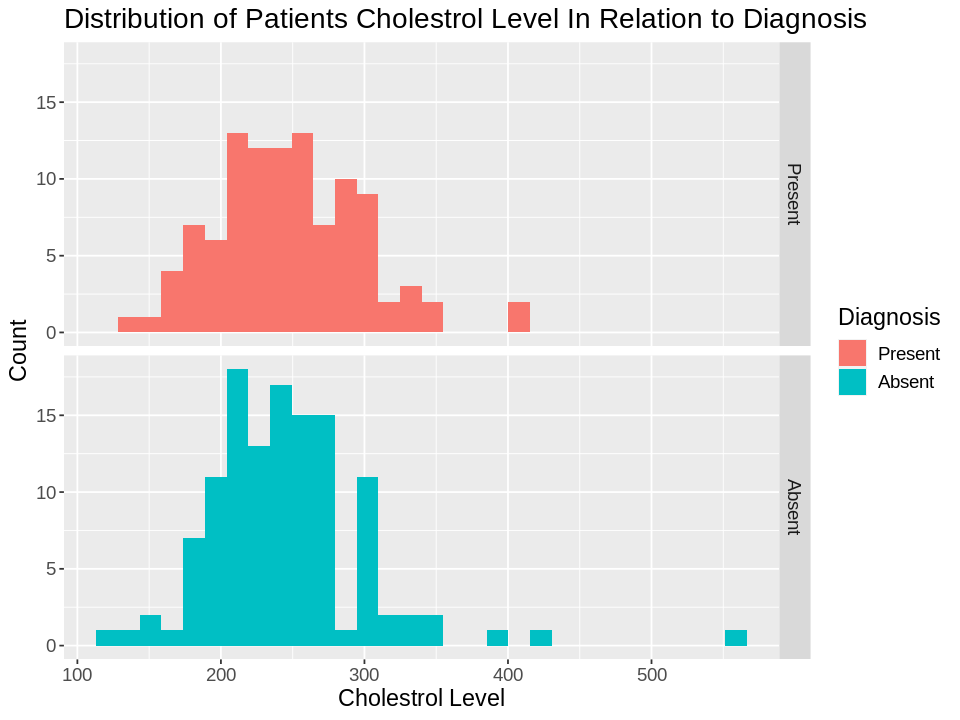

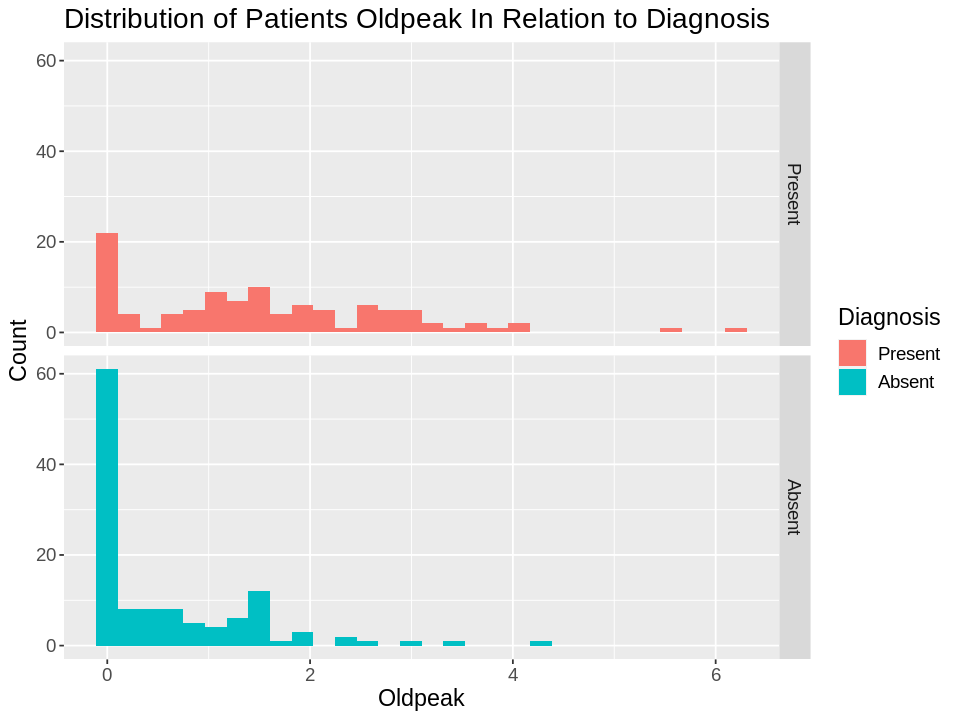

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6)

predictor_age <- cleveland_train |>
            ggplot(aes(age, fill = diagnosis)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(diagnosis)) +
            labs(x = "Age", y= "Count", fill = "Diagnosis") +
            ggtitle("Distribution of Patients Age In Relation to Diagnosis") +
            theme(text = element_text(size = 14))
predictor_age

predictor_rest_bps<-cleveland_train |>
            ggplot(aes(rest_bps, fill = diagnosis)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(diagnosis)) +
            labs(x = "Rest Blood Pressure", y= "Count", fill = "Diagnosis") +
            ggtitle("Distribution of Patients Resting Blood Pressure In Relation to Diagnosis") +
            theme(text = element_text(size = 14))
predictor_rest_bps

predictor_max_heartrate<-cleveland_train |>
            ggplot(aes(max_heartrate, fill = diagnosis)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(diagnosis)) +
            labs(x = "Max Heartrate", y= "Count", fill = "Diagnosis") +
            ggtitle("Distribution of Patients Max Heart Rate In Relation to Diagnosis") +
            theme(text = element_text(size = 14))
predictor_max_heartrate

predictor_cholestrol<-cleveland_train |>
            ggplot(aes(cholestrol_level, fill = diagnosis)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(diagnosis)) +
            labs(x = "Cholestrol Level", y= "Count", fill = "Diagnosis") +
            ggtitle("Distribution of Patients Cholestrol Level In Relation to Diagnosis") +
            theme(text = element_text(size = 14))
predictor_cholestrol

predictor_oldpeak<-cleveland_train |>
            ggplot(aes(oldpeak, fill = diagnosis)) +
            geom_histogram(bins=30) +
            facet_grid(rows = vars(diagnosis)) +
            labs(x = "Oldpeak", y= "Count", fill = "Diagnosis") +
            ggtitle("Distribution of Patients Oldpeak In Relation to Diagnosis") +
            theme(text = element_text(size = 14))
predictor_oldpeak

**Figure 1:** Histograms showing Distribution of Each Variable

In the visualizations shown in **Figure 1**, we noticed that age and max heartrate have different peak values for the two classes of patients. Therefore, we decided that both these variables can be used for our model. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


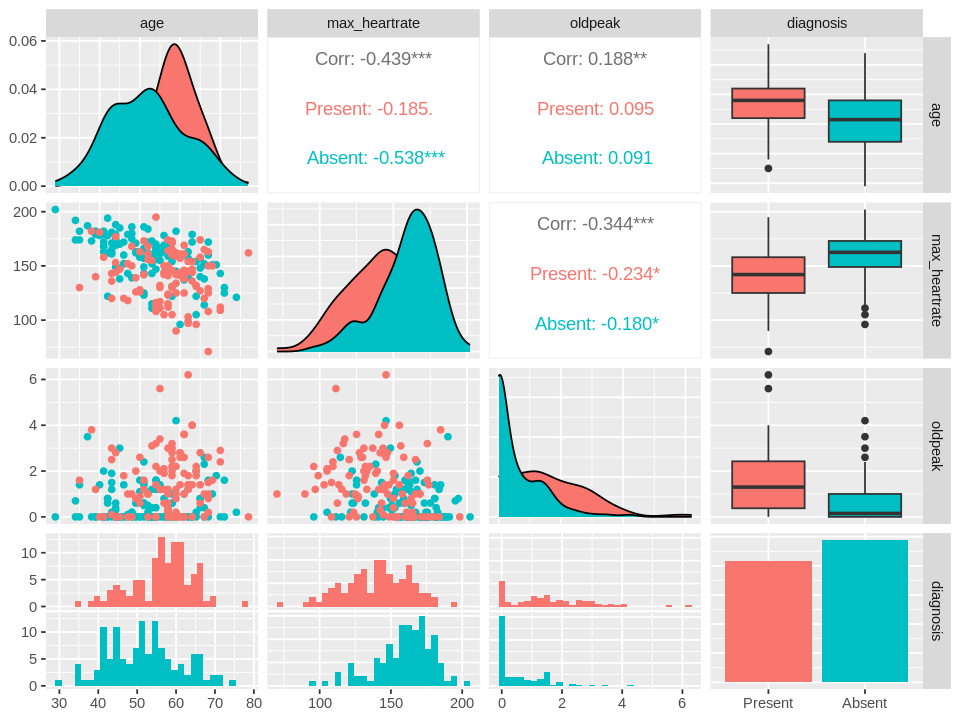

In [8]:
options(repr.plot.width = 8, repr.plot.height = 6)

predictors_plot <- cleveland_train |>
                select(1,3,5,6) |>
                ggpairs(aes(color=diagnosis))
predictors_plot

**Figure 2:** Matrix Plot showing the relation between chosen predictor variables.

Using the exploratory data analysis shown above, we established that our ideal predictor variables are age, max_heartrate, and oldpeak. We followed the rule of reiterating in visualizations by using both histograms and a **ggpairs matrix plot** to confidently decide which variables will be used to train the model. Hence, our summary statistics in **Table 3** combined with visualizations in **Figures 1 and 2** helped us gain a better understanding of what predictors should be used.

### **Training the Model**

We determined the percentage of the majority classifier to set a benchmark to compare our model's accuracy to. The percentage came out to be 54% for Absent meaning if all the observations in the testing data were labelled as Absent, our accuracy would be approximately 54% as it is the majority class.

In [9]:
proportions <- cleveland_train |>
group_by(diagnosis) |>
summarize(n = n()) |>
mutate(percent = 100*n/nrow(cleveland_train))

proportions

diagnosis,n,percent
<fct>,<int>,<dbl>
Present,104,46.0177
Absent,122,53.9823


We then tuned the model to determine the best value of k. After experimenting with several ranges of k values, we came the the conclusion that values between 75 and 100 are providing the highest accuracies, and hence the plot below only shows this limited range. For training our model, <br>
- We first built the recipe using `recipe()` and scale and center our predictor variables which are Age, Mac Heartrate and Oldpeak.
- Using `vfold_cv()`, we performed a 5-fold cross validation on the training data.
- We then passed the different validation sets and the model and recipe to `tune_grid()` to find the accuracies for different k values.
- Finally, we plotted the graph of Neighbors vs Accuracy estimate to decide our value of k.

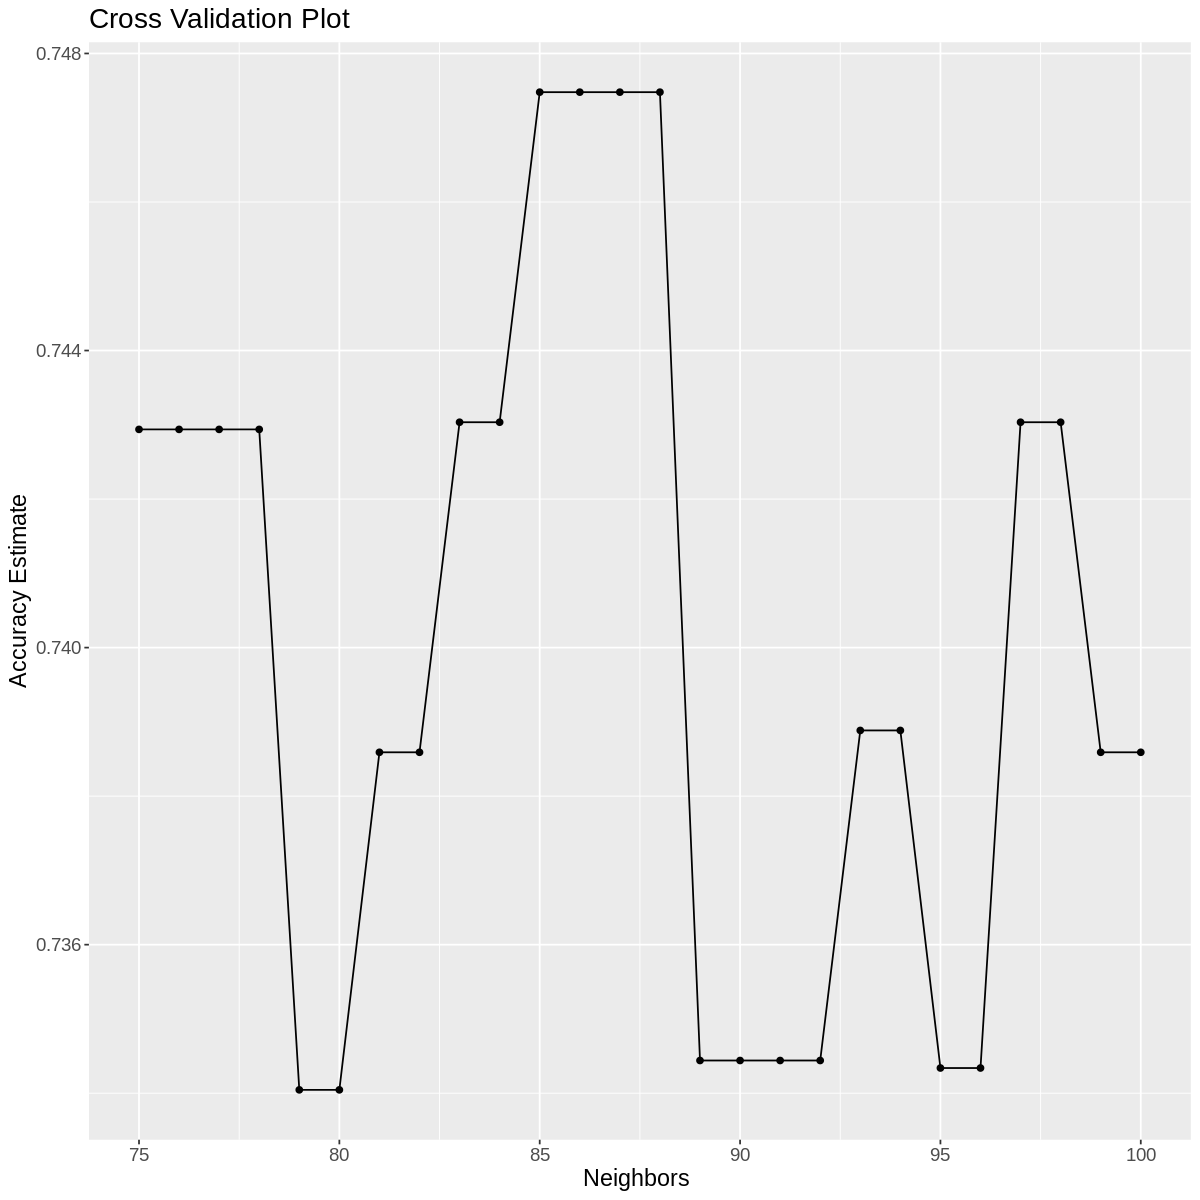

In [47]:
set.seed(2221)

heart_recipe <- recipe(diagnosis ~ age+max_heartrate+oldpeak, data = cleveland_train) |>
                step_normalize(all_predictors())

heart_vfold <- vfold_cv(cleveland_train, v = 5, strata = diagnosis)

heart_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 75, to = 100, by = 1))

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_tune) |>
    tune_grid(resamples = heart_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- heart_fit |> 
      filter(.metric == "accuracy")

options(repr.plot.width = 10, repr.plot.height = 10)
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors ", y = "Accuracy Estimate", title = "Cross Validation Plot") +
      theme(text = element_text(size = 14))

cross_val_plot

**Figure 3:** Plot of Neighbors vs Accuracy

From the plot above, we can clearly see that **k = 85** is be an appropriate value for our model. Hence, we finally created our model in the code cell below and retrain the classifier using the `fit()` function. *(We reused the heart_recipe as it is used to specify what variables are used in the algorithm and is not affected by changes in the k value)*

In [49]:
heart_model <- nearest_neighbor(weight_func = "rectangular", neighbor = 85) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_final_fit <- workflow() |>
            add_recipe(heart_recipe) |>
            add_model(heart_model) |>
            fit(data = cleveland_train)

We then used the `predict()` and `bind_cols()` functions to create a table of predicted values from the classifier on the test set.

In [51]:
heart_predictions <- heart_final_fit |>
                    predict(cleveland_test) |>
                    bind_cols(cleveland_test)
heart_predictions

.pred_class,age,rest_bps,max_heartrate,cholestrol_level,oldpeak,diagnosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Absent,41,130,172,204,1.4,Absent
Present,62,140,160,268,3.6,Present
Absent,57,120,163,354,0.6,Absent
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Absent,58,125,144,220,0.4,Absent
Absent,45,110,132,264,1.2,Present
Present,68,144,141,193,3.4,Present


**Table 5:** A table of prediction results

### **Visualizing the Predictions**

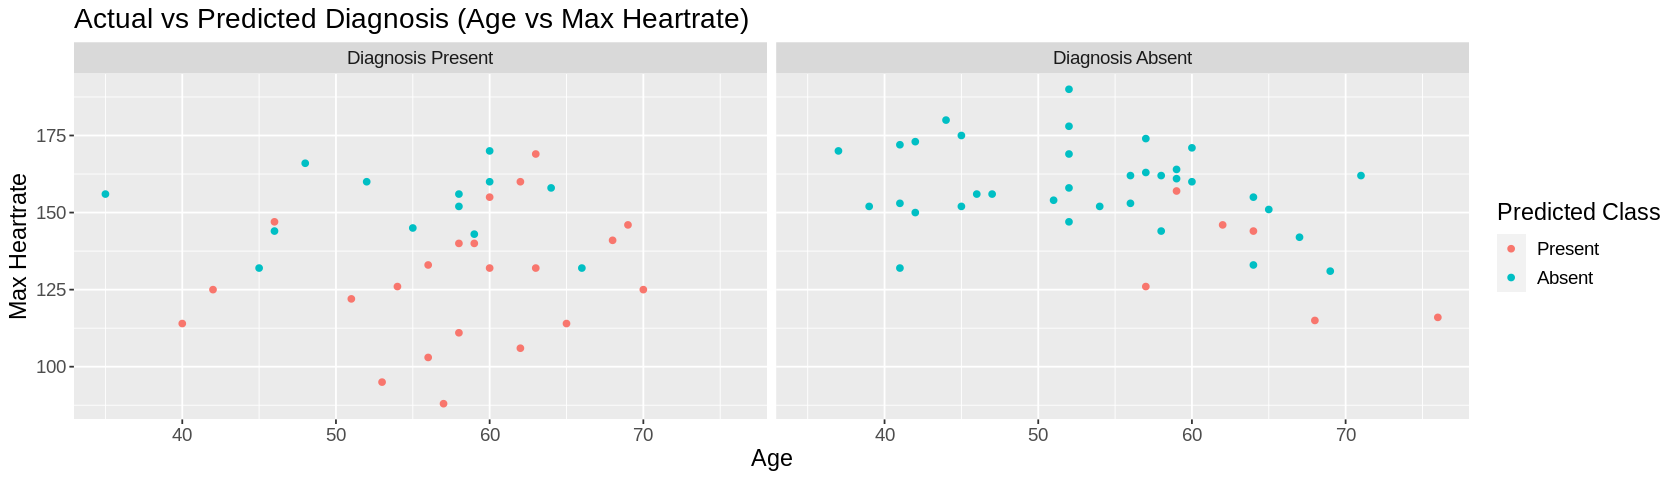

In [52]:
options(repr.plot.width = 14, repr.plot.height = 4)

age_heartrate_viz <- heart_predictions |>
    ggplot(aes(x = age, y = max_heartrate, color = .pred_class)) +
    geom_point() +
    labs(x = "Age", y = "Max Heartrate", color = "Predicted Class") +
    facet_wrap(~ diagnosis, labeller = labeller(diagnosis = c(Present = "Diagnosis Present", Absent = "Diagnosis Absent"))) + 
    theme(text = element_text(size = 14)) +
    ggtitle("Actual vs Predicted Diagnosis (Age vs Max Heartrate)")
age_heartrate_viz

**Figure 4:** Visualizing the analysis in terms of age and max heartrate

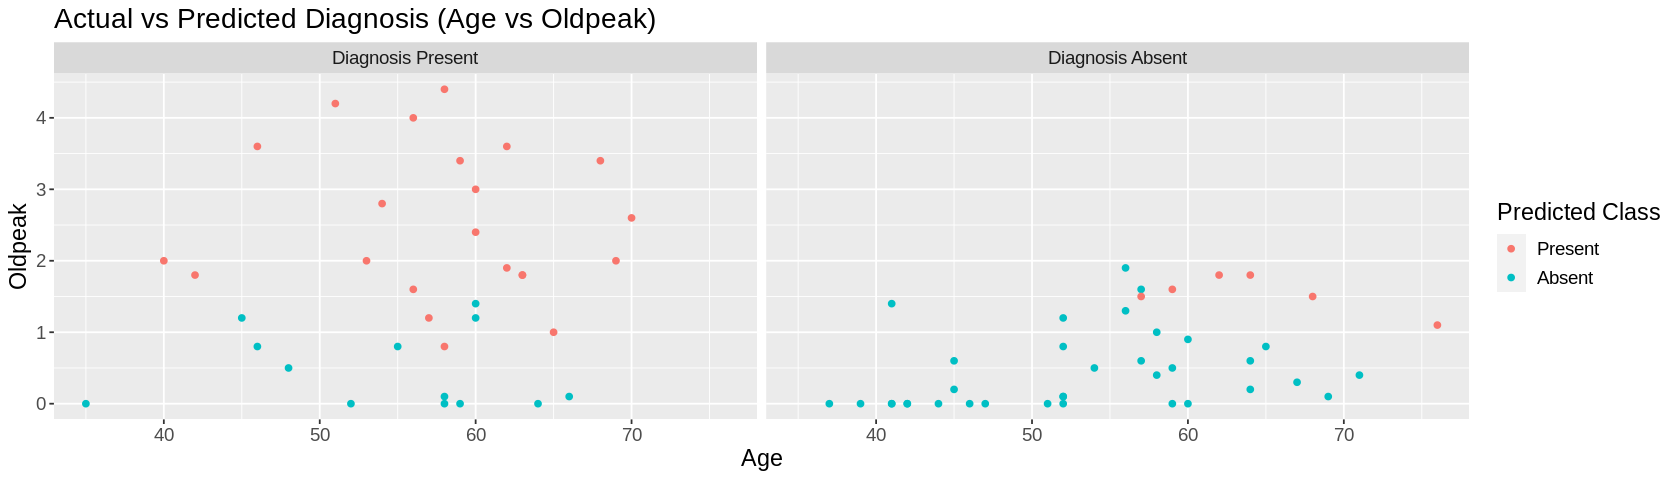

In [53]:
age_oldpeak_viz <- heart_predictions |>
    ggplot(aes(x = age, y = oldpeak, color = .pred_class)) +
    geom_point() +
    labs(x = "Age", y = "Oldpeak", color = "Predicted Class") +
    facet_wrap(~ diagnosis, labeller = labeller(diagnosis = c(Present = "Diagnosis Present", Absent = "Diagnosis Absent"))) + 
    theme(text = element_text(size = 14)) +
    ggtitle("Actual vs Predicted Diagnosis (Age vs Oldpeak)")
age_oldpeak_viz

**Figure 5:** Visualizing the analysis in terms of age and oldpeak

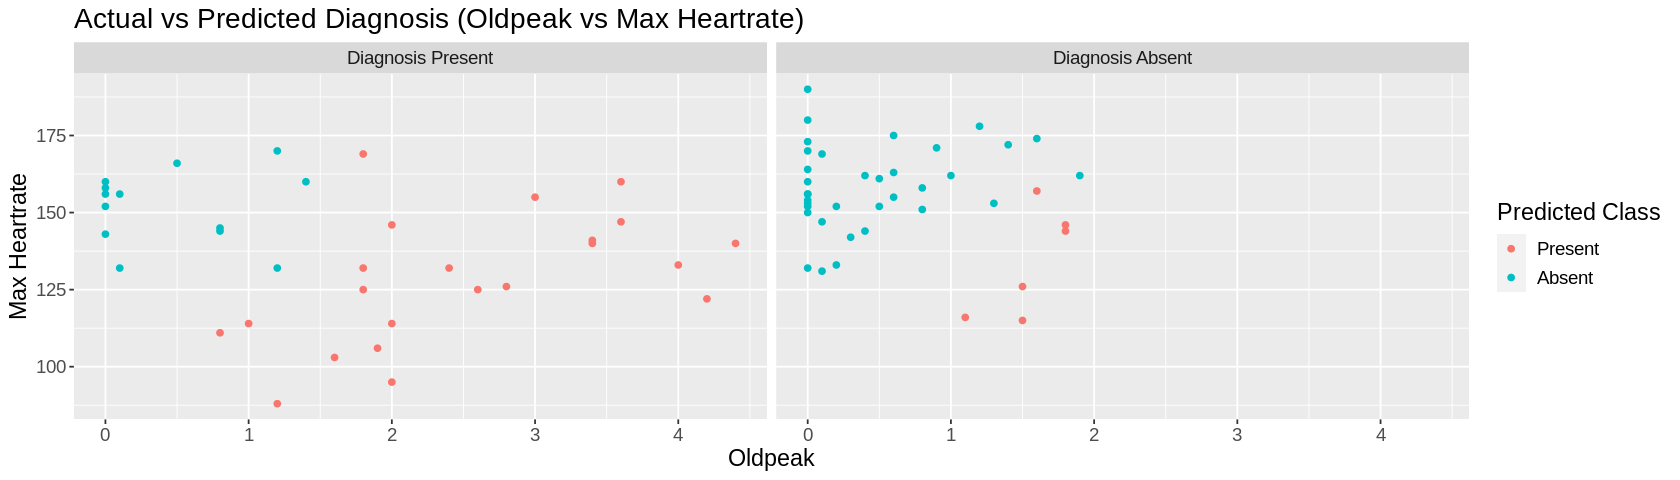

In [54]:
oldpeak_heartrate_viz <- heart_predictions |>
    ggplot(aes(x = oldpeak, y = max_heartrate, color = .pred_class)) +
    geom_point() +
    labs(x = "Oldpeak", y = "Max Heartrate", color = "Predicted Class") +
    facet_wrap(~ diagnosis, labeller = labeller(diagnosis = c(Present = "Diagnosis Present", Absent = "Diagnosis Absent"))) + 
    theme(text = element_text(size = 14)) +
    ggtitle("Actual vs Predicted Diagnosis (Oldpeak vs Max Heartrate)")
oldpeak_heartrate_viz

**Figure 6:** Visualizing the analysis in terms of oldpeak and max heartrate

### **Classification Results**

We calculated the accuracy of our classification model using the `metrics()` function. The accuracy of the classifier on the testing data was 75%, which is relatively higher than the 54% that the majority classifier would have given us. However, it is definitely not ideal specially in the case of predicting the risk of heart disease since a serious diagnosis would ideally require a much higher accuracy.

In [55]:
heart_accuracy <- heart_predictions |>
                metrics(truth = diagnosis, estimate = .pred_class) |>
                filter(.metric == "accuracy")
heart_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.75


**Table 6:** Accuracy of Classification Model

Further, we created a confusion matrix for the predictions using the `conf_mat()` function. We found that 19 observations were labelled incorrectly out of which more than two-thirds were labelled as Absent when the true value was Present. This is a serious issue since we do not want patients who have heart disease to be classified as healthy.

In [56]:
heart_predictions_confmat <- heart_predictions |>
                            conf_mat(truth = diagnosis, estimate = .pred_class)
heart_predictions_confmat

          Truth
Prediction Present Absent
   Present      22      6
   Absent       13     35

**Table 7:** Confusion Matrix for the predictions from the model

### **Discussion:**

**Findings**

Originally we hypothesized that age, cholestrol level, blood pressure, max heartrate and oldpeak will be able to correctly predict the diagnosis. We obtained a 75% prediction accuracy, which means the model somewhat gave correct predictions, but not to an extent that will be usable in real diagnosis.
We also hypothesized that patients with a positive diagnosis risk will be in higher age groups and have overall higher blood pressure, cholestrol levels, max heartrates and oldpeak values.

We have succesfully coded and created our classification algorithm model using k = 85, and after testing it against the Testing Set and putting it through a confusion matrix to determine overall performance, we have determined that our classification model has a accuracy rate of 75%

In [ ]:
findings_present <- filter(heart_predictions, .pred_class == "Present", diagnosis == "Present")

findings_present

**Table 8:** Accuratey predicted positive (present) results with all values displayed

In [ ]:
findings_absent <- filter(heart_predictions, .pred_class == "Absent", diagnosis == "Absent")

findings_absent

**Table 9:** Accuratey predicted negative (absent) results with all values displayed

Based on the two comparisons of accurately predicted results in **Table 8 and 9**, we cannot confirm our hypothesis that patients who are categorized with a present in risk have a higher age, blood pressure, and heart rate. There seems to be a higher oldpeak value in those who are at risk of a heart disease.

**Possible Improvements for Future Model Training**

There are several fluctuations in the graph and several local maximums can be observed. However, it is important to keep in mind that a bigger k value will contribute to a requirement for a higher computational power. In addition, considering that our training model size is 226, a k value of 85 since that is taking up a vote of 1/3 of the observations. This will be discussed further in the discussions section of the project.

Our choice of k value could impact the accuracy of the model. We used a relatively high k value which might have lead to underfitting as the neighboring points start having an averaging effect. There were a couple of peaks for lower k values that could potentially decrease the averaging effect, even with a less prediction accuracy percentage. This is something to be explored further as we would want to know if a lower k value would potentially predict a more accurate result. 


**Conclusion**

Ultimately, our conclusions revealed that the variables maximum heart rate and age alone are not sufficient in predicting the risk of heart disease in patients with the desired precision. These findings could lead to future questions such as: Are certain variables more influential and certain when it comes to classifying a patient’s risk of heart disease? With further research, the classification model could be used to diagnose diseases early on so proper treatment can be administered to affected patients in a timely fashion. This is important because an early diagnosis would increase the medical help available and can possibly mitigate the detrimental effects of the disease upon the individual. 

#### **References:**

Campbell, E. (2020, September 18). Cleveland is now the poorest big city in the country. *The Center for Community Solutions*. Retrieved April 2, 2023, from https://www.communitysolutions.com/cleveland-now-poorest-big-city-country/ 

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. *Centers for Disease Control and Prevention*. Retrieved April 2, 2023, from https://www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=Narrowed%20arteries%20can%20cause%20chest,the%20rest%20of%20your%20body.&amp;text=Over%20time%2C%20CAD%20can%20weaken,blood%20the%20way%20it%20should. 

Janosi, A., Steinbrunn, W., Pfisterer, M., Detrano, R. (1988). Heart Disease Data Set. *UCI Machine Learning Repository*. Retrieved April 2, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 

Ralapanawa, U., & Sivakanesan, R. (2021). Epidemiology and the Magnitude of Coronary Artery Disease and Acute Coronary Syndrome: A Narrative Review. *Journal of epidemiology and global health, 11*(2), 169–177. https://doi.org/10.2991/jegh.k.201217.001

U.S. Department of Health and Human Services. What is coronary heart disease? *National Heart Lung and Blood Institute*. Retrieved April 2, 2023, from https://www.nhlbi.nih.gov/health/coronary-heart-disease#:~:text=About%2018.2%20million%20American%20adults,the%20surface%20of%20the%20heart. 